# Kaggle Competition
## Javier Palomares

### Data Reading

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

In [2]:
train = pd.read_csv('./input/train_final.csv')
test = pd.read_csv('./input/test_final.csv')

In [3]:
train.head()

,Id,Y,f1,f2,f3,f4,f5,f6,f7,f8,...,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24
0,1,1,25884,1,33.63,118596,1,0,118595,125738,...,1945,118450,119184,1,121372,1,1,1,2,1
1,2,1,34346,1,10.62,118041,1,0,117902,130913,...,15385,117945,292795,1,259173,1,1,1,1,1
2,3,1,34923,1,1.77,118327,1,0,117961,124402,...,7547,118933,290919,1,118784,1,1,1,1,1
3,4,1,80926,1,30.09,118300,1,0,117961,301218,...,4933,118458,118331,1,307024,1,1,1,2,1
4,5,1,4674,1,1.77,119921,1,0,119920,302830,...,13836,142145,4673,1,128230,1,1,1,620,1


In [4]:
train.shape

(16383, 26)

In [5]:
y = train.Y

(array([  948.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 15435.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

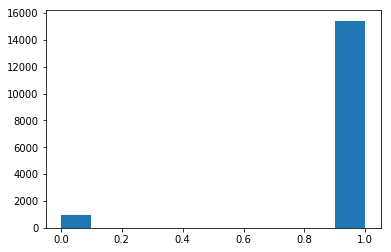

In [6]:
plt.hist(y)

It looks like the y variable is binary classification variable

In [34]:
x_train = train.loc[:,'f1':'f24']

### Data Preprocessing

In [8]:
# get the numberical features 
numeric_feats = x_train.dtypes[x_train.dtypes != "object"].index
print(numeric_feats)

Index(['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11',
       'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21',
       'f22', 'f23', 'f24'],
      dtype='object')


All features are numeric.

I'll find skewed features and drop those with a skewness greater than .85

In [9]:
# find skewed features
skew_to_drop = .85
#compute skewness
skewedness_factor = x_train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewedness_factor[skewedness_factor > skew_to_drop].index
print(skewed_feats)

Index(['f1', 'f2', 'f3', 'f5', 'f6', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13',
       'f15', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24'],
      dtype='object')


(array([1.5801e+04, 4.7700e+02, 7.8000e+01, 0.0000e+00, 1.6000e+01,
        9.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([1. , 1.7, 2.4, 3.1, 3.8, 4.5, 5.2, 5.9, 6.6, 7.3, 8. ]),
 <a list of 10 Patch objects>)

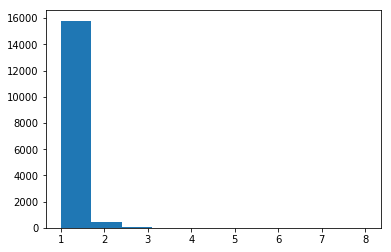

In [35]:
plt.hist(x_train.f20)

It looks like most of the features are skewed, but it also looks like several of the columns are integer valued

I'll look for binary columns and won't apply any preprocessing to those

In [11]:
def get_binary_cols(df):
    bin_cols = [col for col in df if 
               df[col].dropna().value_counts().index.isin([0,1]).all()]
    return bin_cols

In [12]:
bin_cols = get_binary_cols(x_train)

In [13]:
print(bin_cols)

[]


There's no binary columns

In [40]:
np.log1p(-1)

/home/jpalomares/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log1p
  """Entry point for launching an IPython kernel.


-inf

In [41]:
# fill NA's with the mean of the column
x_train = x_train.fillna(x_train.mean())
z = np.log1p(x_train[skewed_feats])

/home/jpalomares/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log1p
  This is separate from the ipykernel package so we can avoid doing imports until


(array([1.5801e+04, 0.0000e+00, 4.7700e+02, 0.0000e+00, 7.8000e+01,
        0.0000e+00, 1.6000e+01, 9.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([0.69314718, 0.84355492, 0.99396266, 1.1443704 , 1.29477814,
        1.44518588, 1.59559362, 1.74600136, 1.8964091 , 2.04681684,
        2.19722458]),
 <a list of 10 Patch objects>)

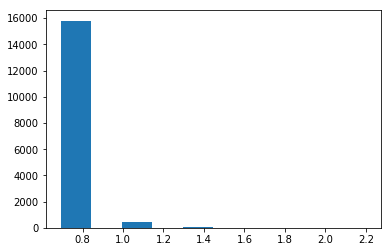

In [43]:
plt.hist(z.f20)

### Models
I'll first try fitting a logistic regression classifier

In [48]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
# function to compute rmse error
def rmse(predicted,target):
    return np.sqrt(np.mean((predicted-target)**2))
# function to compute the root mean squared error of the cross validation
def rmse_cv(model,X_train,y):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)

In [49]:
n_alphas = 200
alphas = np.logspace(-5, 5, n_alphas).tolist()
model_logistic = LogisticRegressionCV(Cs=alphas,cv=10,solver='liblinear').fit(x_train,y)

In [ ]:
rmse_cv(model_logistic,x_train,y).mean()

In [78]:
x_test = test.loc[:,'f1':'f24']
y_pred = model_logistic.predict_prod(x_test)[:,1]
ids = test.Id

AttributeError: 'LogisticRegressionCV' object has no attribute 'predict_prod'

In [57]:
def write_predictions(filename,header,ids,y_pred):
    f = open(filename,'w')
    numRows = len(ids)
    f.write(header)
    for i in range(numRows):
        idNum = ids[i]
        y = y_pred[i]
        f.write("{},{}\n".format(idNum,y))
    f.close()

In [63]:
import datetime
write_predictions("predictions/prediction"+datetime.datetime.now().isoformat() + ".csv","Id,Y\n",ids,y_pred)

In [87]:
vanilla_logistic = LogisticRegression(C=1e-5,solver='lbfgs').fit(x_train,y)

In [88]:
y_pred_vanilla = vanilla_logistic.predict_proba(x_test)[:,1]

In [89]:
print(y_pred_vanilla)

[0.93979353 0.94021113 0.95522887 ... 0.94096549 0.93982833 0.93949173]


In [77]:
write_predictions("predictions/pure_vanilla_"+datetime.datetime.now().isoformat()+".csv","Id,Y\n",ids,y_pred_vanilla)

In [84]:
c = model_logistic.C_

In [90]:
vanilla_logistic.C

1e-05